In [4]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler
from torch.amp import autocast
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm

# IMPORTANT: Disable torch.compile for ARM/CPU compatibility
import torch._dynamo
torch._dynamo.config.suppress_errors = True
torch._dynamo.config.disable = True

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Running in CPU mode")
print("✓ torch.compile disabled for maximum compatibility")

PyTorch version: 2.9.0+cu130
CUDA available: True
CUDA version: 13.0
GPU: NVIDIA GB10
✓ torch.compile disabled for maximum compatibility


## 1. Device Setup and Configuration

In [5]:
# Automatic device detection (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    # Enable cuDNN benchmarking for better performance
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

Using device: cuda


## 2. Define Modern CNN Architecture

In [6]:
class ModernCNN(nn.Module):
    """Modern CNN with BatchNorm and Dropout for better regularization"""
    
    def __init__(self, num_classes=10):
        super(ModernCNN, self).__init__()
        
        # Convolutional layers with BatchNorm
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers with Dropout
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(84, num_classes)
        
        # Use ReLU activation
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        # Flatten
        x = torch.flatten(x, 1)
        
        # FC layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

print("Model architecture defined successfully!")


Model architecture defined successfully!


In [7]:
# Initialize model and move to device
model = ModernCNN(num_classes=10).to(device)

print("\nModel architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Note: torch.compile is disabled for compatibility with ARM/CPU systems
# The model will train fine without it!
print("\n✓ Model initialized successfully (running in standard mode)")


Model architecture:
ModernCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)

Total parameters: 62,050
Trainable parameters: 62,050

✓ Model initialized successfully (running in standard mode)


## 3. CIFAR-10 Dataset Loading with Modern Data Augmentation

In [8]:
# Modern data augmentation pipeline
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(1.0, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load datasets
trainset = datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=train_transform
)

testset = datasets.CIFAR10(
    root='./data', 
    train=False, 
    download=True, 
    transform=test_transform
)

# Create DataLoaders with modern settings
batch_size = 128
num_workers = 4 if torch.cuda.is_available() else 2

trainloader = DataLoader(
    trainset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if num_workers > 0 else False
)

testloader = DataLoader(
    testset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if num_workers > 0 else False
)

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Batch size: {batch_size}")
print(f"Number of batches (train): {len(trainloader)}")
print(f"Number of batches (test): {len(testloader)}")

100%|██████████| 170M/170M [00:19<00:00, 8.67MB/s] 


Training samples: 50000
Test samples: 10000
Batch size: 128
Number of batches (train): 391
Number of batches (test): 79


## 4. Training Setup with Modern Optimizers and Schedulers

In [9]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Modern optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    epochs=10,
    steps_per_epoch=len(trainloader)
)

# Mixed precision training (for GPU)
use_amp = torch.cuda.is_available()
scaler = GradScaler() if use_amp else None

print(f"Using mixed precision training: {use_amp}")

Using mixed precision training: True


/tmp/ipykernel_6874/1514044329.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None


## 5. Modern Training Loop with Progress Bars

In [10]:
def train_epoch(model, trainloader, criterion, optimizer, scaler, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(trainloader, desc='Training', leave=False)
    
    for inputs, labels in pbar:
        # Move data to device
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
        
        # Mixed precision training
        if scaler is not None:
            with autocast(device_type="cuda", enabled=use_amp):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{running_loss/(pbar.n+1):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    return running_loss / len(trainloader), 100. * correct / total

@torch.no_grad()
def validate(model, testloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(testloader, desc='Validation', leave=False)
    
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': f'{running_loss/(pbar.n+1):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    return running_loss / len(testloader), 100. * correct / total

# Training loop
num_epochs = 10
best_acc = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Starting training...\n")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss, train_acc = train_epoch(
        model, trainloader, criterion, optimizer, scaler, device
    )
    
    # Validate
    val_loss, val_acc = validate(model, testloader, criterion, device)
    
    # Update learning rate based on validation loss
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch summary
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, 'best_model.pth')
        print(f"✓ Best model saved with accuracy: {best_acc:.2f}%")
    
    print()

print(f"Training completed! Best validation accuracy: {best_acc:.2f}%")

Starting training...

Epoch 1/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.9684 | Train Acc: 25.87%
Val Loss: 1.6070 | Val Acc: 41.21%
✓ Best model saved with accuracy: 41.21%

Epoch 2/10


/home/aispark/Project/CV/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:204: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.6848 | Train Acc: 36.87%
Val Loss: 1.5382 | Val Acc: 43.68%
✓ Best model saved with accuracy: 43.68%

Epoch 3/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.5929 | Train Acc: 41.24%
Val Loss: 1.3990 | Val Acc: 48.97%
✓ Best model saved with accuracy: 48.97%

Epoch 4/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.5466 | Train Acc: 43.38%
Val Loss: 1.3695 | Val Acc: 50.07%
✓ Best model saved with accuracy: 50.07%

Epoch 5/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.5038 | Train Acc: 45.39%
Val Loss: 1.3717 | Val Acc: 50.35%
✓ Best model saved with accuracy: 50.35%

Epoch 6/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.4741 | Train Acc: 46.40%
Val Loss: 1.2944 | Val Acc: 53.39%
✓ Best model saved with accuracy: 53.39%

Epoch 7/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.4547 | Train Acc: 47.76%
Val Loss: 1.2829 | Val Acc: 53.41%
✓ Best model saved with accuracy: 53.41%

Epoch 8/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.4316 | Train Acc: 48.78%
Val Loss: 1.2873 | Val Acc: 53.63%
✓ Best model saved with accuracy: 53.63%

Epoch 9/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.4201 | Train Acc: 49.23%
Val Loss: 1.2552 | Val Acc: 54.70%
✓ Best model saved with accuracy: 54.70%

Epoch 10/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.4056 | Train Acc: 50.08%
Val Loss: 1.2591 | Val Acc: 54.43%

Training completed! Best validation accuracy: 54.70%


## 6. Plot Training History

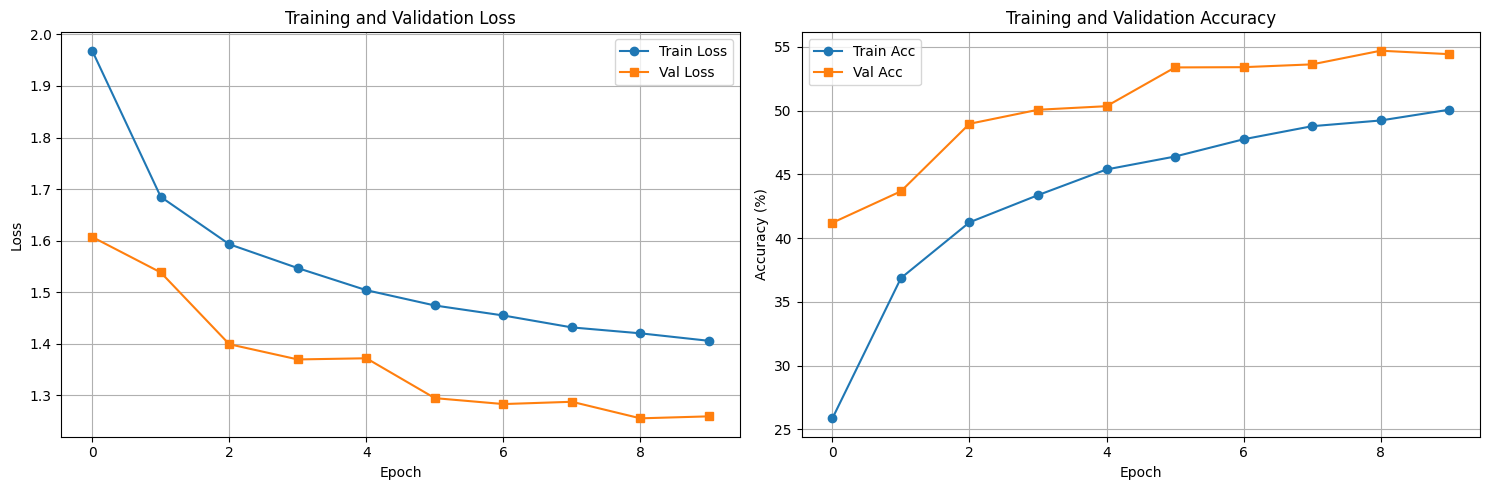

In [11]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Comprehensive Evaluation

In [12]:
# Load best model
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1} with accuracy {checkpoint['val_acc']:.2f}%")

# Collect predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(testloader, desc='Evaluating'):
        inputs = inputs.to(device, non_blocking=True)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

Loaded best model from epoch 9 with accuracy 54.70%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

## 8. Confusion Matrix and Classification Report

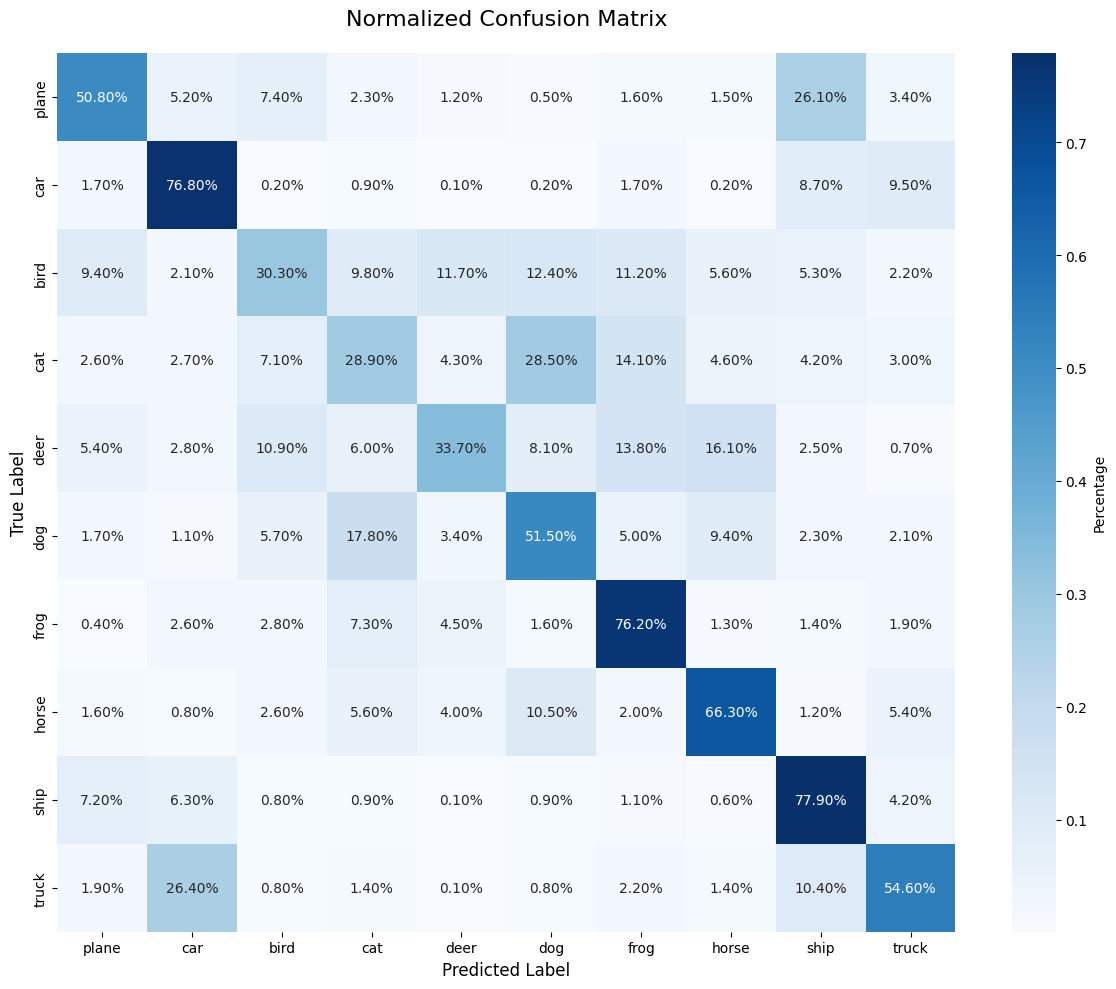


Classification Report:
              precision    recall  f1-score   support

       plane     0.6143    0.5080    0.5561      1000
         car     0.6057    0.7680    0.6772      1000
        bird     0.4417    0.3030    0.3594      1000
         cat     0.3572    0.2890    0.3195      1000
        deer     0.5341    0.3370    0.4132      1000
         dog     0.4478    0.5150    0.4791      1000
        frog     0.5912    0.7620    0.6658      1000
       horse     0.6196    0.6630    0.6406      1000
        ship     0.5564    0.7790    0.6492      1000
       truck     0.6276    0.5460    0.5840      1000

    accuracy                         0.5470     10000
   macro avg     0.5396    0.5470    0.5344     10000
weighted avg     0.5396    0.5470    0.5344     10000



In [13]:
# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_normalized, 
    annot=True, 
    fmt=".2%", 
    cmap="Blues", 
    xticklabels=classes, 
    yticklabels=classes,
    cbar_kws={'label': 'Percentage'}
)
plt.title("Normalized Confusion Matrix", fontsize=16, pad=20)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print classification report
print("\nClassification Report:")
print("=" * 60)
class_report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
print(class_report)

## 9. Per-Class Accuracy Analysis

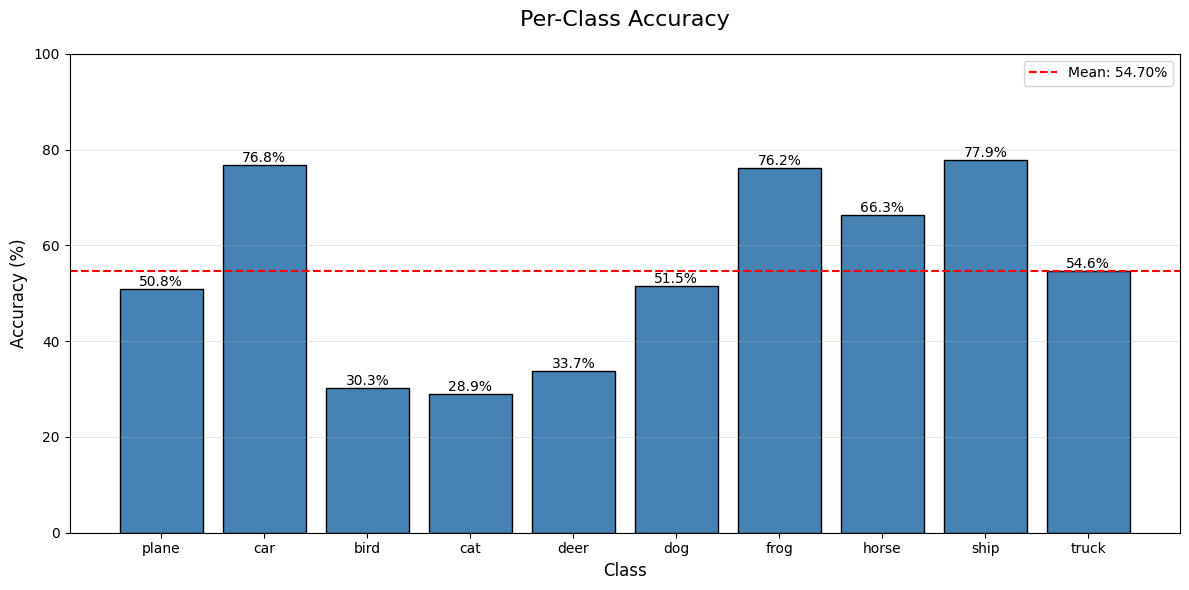


Per-Class Accuracy:
plane     :  50.80%
car       :  76.80%
bird      :  30.30%
cat       :  28.90%
deer      :  33.70%
dog       :  51.50%
frog      :  76.20%
horse     :  66.30%
ship      :  77.90%
truck     :  54.60%
Mean      :  54.70%


In [14]:
# Calculate per-class accuracy
class_correct = np.zeros(10)
class_total = np.zeros(10)

for i in range(len(all_labels)):
    label = all_labels[i]
    class_total[label] += 1
    if all_preds[i] == label:
        class_correct[label] += 1

class_accuracy = 100 * class_correct / class_total

# Plot per-class accuracy
plt.figure(figsize=(12, 6))
bars = plt.bar(classes, class_accuracy, color='steelblue', edgecolor='black')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Per-Class Accuracy', fontsize=16, pad=20)
plt.ylim([0, 100])
plt.axhline(y=class_accuracy.mean(), color='red', linestyle='--', label=f'Mean: {class_accuracy.mean():.2f}%')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom', fontsize=10)

plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# Print per-class statistics
print("\nPer-Class Accuracy:")
print("=" * 40)
for i, class_name in enumerate(classes):
    print(f"{class_name:10s}: {class_accuracy[i]:6.2f}%")
print("=" * 40)
print(f"{'Mean':10s}: {class_accuracy.mean():6.2f}%")

## 10. Save Final Model and Summary

In [15]:
# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'classes': classes,
    'best_acc': best_acc,
}, 'final_model.pth')

# Print summary
print("\n" + "=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)
print(f"Device used: {device}")
print(f"Mixed precision training: {use_amp}")
print(f"Number of epochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print(f"Best validation accuracy: {best_acc:.2f}%")
print(f"Final train accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final validation accuracy: {history['val_acc'][-1]:.2f}%")
print("=" * 60)
print("\nModel and results saved successfully!")
print("Files created:")
print("  - best_model.pth")
print("  - final_model.pth")
print("  - training_history.png")
print("  - confusion_matrix.png")
print("  - per_class_accuracy.png")


TRAINING SUMMARY
Device used: cuda
Mixed precision training: True
Number of epochs: 10
Batch size: 128
Best validation accuracy: 54.70%
Final train accuracy: 50.08%
Final validation accuracy: 54.43%

Model and results saved successfully!
Files created:
  - best_model.pth
  - final_model.pth
  - training_history.png
  - confusion_matrix.png
  - per_class_accuracy.png
